In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
global_map = cv2.imread('../maps/test_global.png')
global_map = cv2.cvtColor(global_map, cv2.COLOR_RGB2GRAY)
local_map = cv2.imread('../maps/test_local.png')
local_map = cv2.cvtColor(local_map, cv2.COLOR_RGB2GRAY)


In [3]:
def imshow(im):
    plt.xticks([]), plt.yticks([])
    plt.imshow(im, cmap="gray")
    plt.show()

In [4]:
def setup_map(im):
    imx = cv2.Sobel(im, cv2.CV_32F, 1, 0, ksize=5)
    imy = cv2.Sobel(im, cv2.CV_32F, 0, 1, ksize=5)
    mag = np.sqrt(imx**2 + imy**2)
    temp = np.ones(im.shape)
    temp[imx == 0] = np.nan
    angle = np.where(temp == 1, np.arctan2(imy, imx), temp)
    return mag, angle

In [5]:
global_mag, global_ang = setup_map(global_map)
local_mag, local_ang = setup_map(local_map)
lw,lh = local_map.shape

In [6]:
def drawArrow(m, px, py, pt):
    line_len = int(min(m.shape)/30)
    print(m.shape)
    line_width = int(min(m.shape)/100)
    circle_width = int(min(m.shape)/75)
    mc = np.copy(m)
    endx = int(px + line_len*np.cos(pt))
    endy = int(py + line_len*np.sin(pt))
    cv2.circle(mc, (px,py), circle_width, 100, thickness=-1)
    print(line_width)
    return cv2.line(mc, (px,py), (endx, endy), 100, line_width)

(1000, 1000)
10


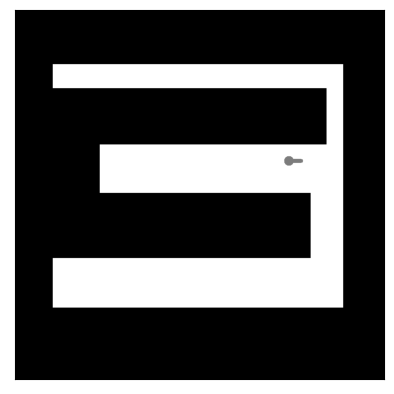

In [7]:
pgx = 740
pgy = 410
pga = 0

arrow_global = drawArrow(global_map, pgx, pgy, pga)
imshow(arrow_global)

(216, 257)
2


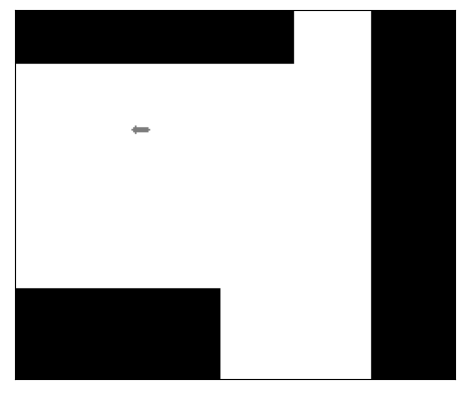

In [8]:
plx = 70
ply = 70
pla = 0

arrow_local = drawArrow(local_map, plx, ply, pla)

imshow(arrow_local)

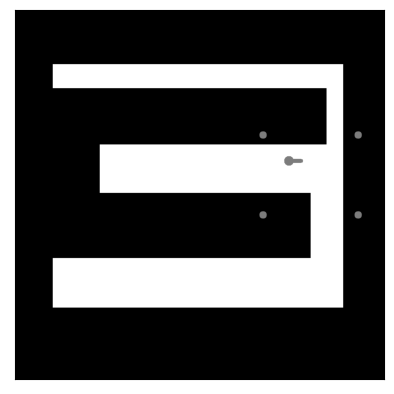

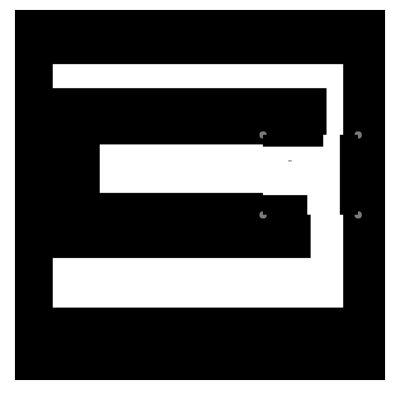

In [9]:
tlg = (int(pgx - plx), int(pgy - ply))
trg = (tlg[0]+lh, tlg[1])
blg = (tlg[0], tlg[1]+lw)
brg = (tlg[0]+lh, tlg[1]+lw)
tmp = np.copy(arrow_global)
cv2.circle(tmp, tlg, 10, 100, -1)
cv2.circle(tmp, trg, 10, 100, -1)
cv2.circle(tmp, blg, 10, 100, -1)
cv2.circle(tmp, brg, 10, 100, -1)
imshow(tmp)
tmp[tlg[1]:tlg[1]+lw, tlg[0]:tlg[0]+lh] = arrow_local
imshow(tmp)

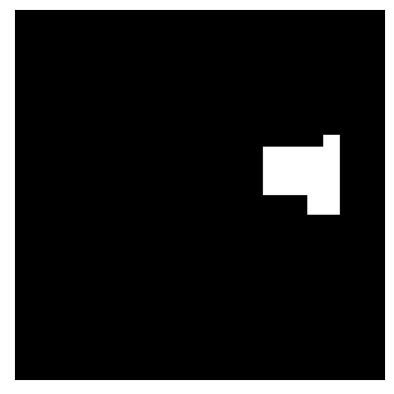

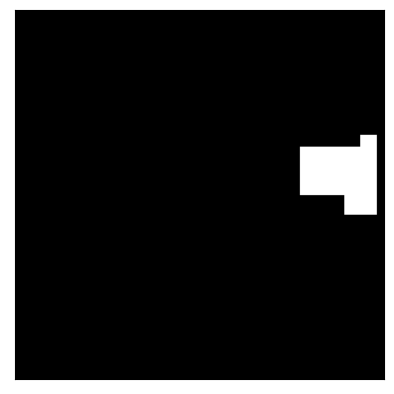

In [10]:
def pad_local(im, size, local_pose, global_pose, pad_value=0):
    lh,lw = im.shape
    pad_width = max(im.shape)
    im_pad = np.full((size[0]+2*pad_width, size[1]+2*pad_width), pad_value)
    dx = pad_width + global_pose[0]- local_pose[0]
    dy = pad_width + global_pose[1]- local_pose[1]
    im_pad[dy:dy+lh,dx:dx+lw] = im
    return im_pad[pad_width:size[0]+pad_width,pad_width:size[1]+pad_width]

    

imshow(pad_local(local_map, global_map.shape, (plx, ply), (pgx, pgy)))
#test to make sure the local map can be partially off the global map
imshow(pad_local(local_map, global_map.shape, (plx-100, ply), (pgx, pgy)))

In [11]:
def generate_particles(pose, std, num):
    particles = np.random.multivariate_normal(pose, [[std, 0],[0,std]], num)
    particles = np.append(np.array(pose), particles)
    particles = particles.reshape((-1,2))
    return particles

In [12]:
def calc_weight(local_ang, local_mag, global_ang):
    weights = 1 - (2 * np.abs(np.arctan(np.sin(local_ang - global_ang) / np.cos(local_ang - global_ang))) / np.pi)
    tmp = np.copy(weights)
    tmp = (tmp + 3.15) *10
    weights[weights<0] = 0
    weights = weights * local_mag
    return np.nansum(weights)

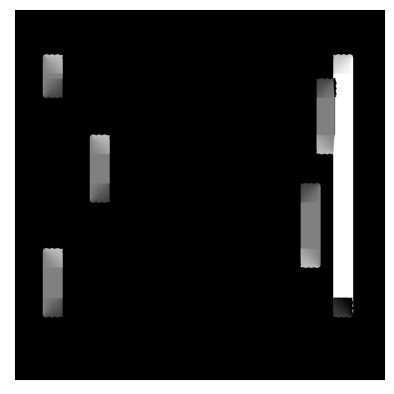

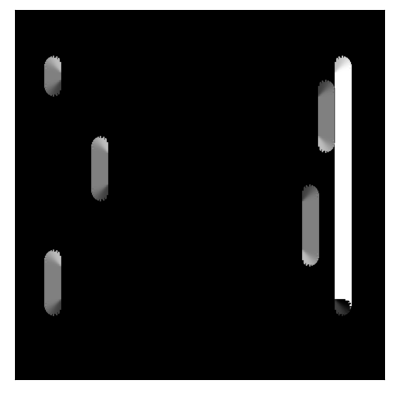

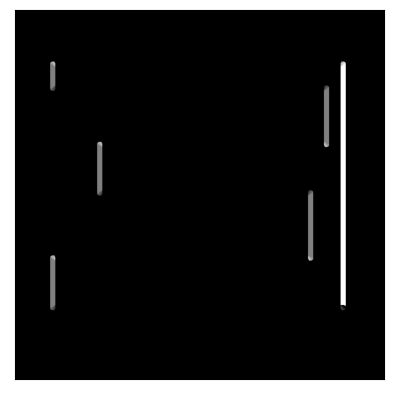

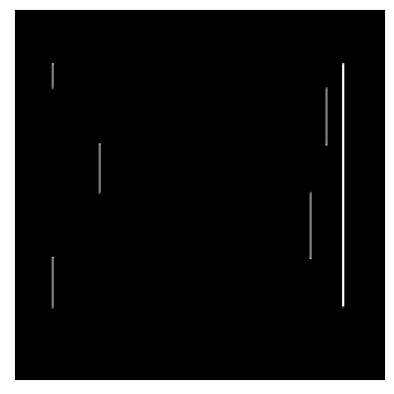

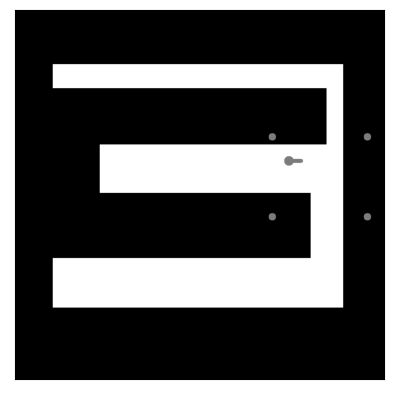

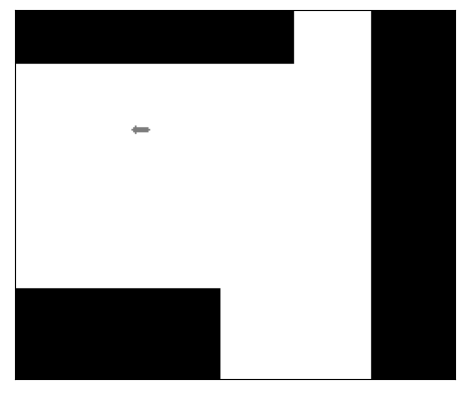

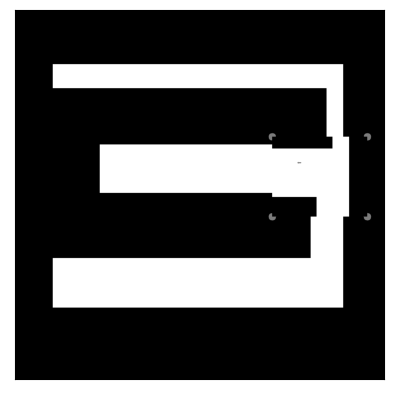

[765.19987938 415.14899279]


In [13]:
def localize(local_ang, local_mag, global_map, pl, pg, gstd=30, std=40, n=50, it=0, rounds=4):
    plx,ply = pl
    pgx,pgy = pg
    global_blur = cv2.GaussianBlur(global_map, (51,51), gstd)
    _, global_ang = setup_map(global_blur)
    tmp = np.copy(global_ang)
    tmp = (tmp + 3.15) * 10
    tmp = np.nan_to_num(tmp, 0)
    imshow(tmp)
    particles = generate_particles((pgx, pgy), std, n)

    weights = []
    for particle in particles:
        particle_mag = pad_local(local_mag, global_map.shape, (plx,ply), particle.astype(int))
        particle_ang = pad_local(local_ang, global_map.shape, (plx,ply), particle.astype(int), pad_value=np.nan)

        weights.append(calc_weight(particle_ang, particle_mag, global_ang))
    
    best_particle = particles[weights.index(max(weights))]
    if it < rounds-1:
        return localize(local_ang, local_mag, global_map, pl, best_particle, gstd=gstd*0.25, std=std*0.25, n=n, it=it+1, rounds=rounds)
    else:
        return best_particle


best_particle = localize(local_ang, local_mag, global_map, (plx,ply), (pgx,pgy))
tlg = (int(best_particle[0] - plx), int(best_particle[1]-ply))
trg = (tlg[0]+lh, tlg[1])
blg = (tlg[0], tlg[1]+lw)
brg = (tlg[0]+lh, tlg[1]+lw)
tmp = np.copy(arrow_global)
cv2.circle(tmp, tlg, 10, 100, -1)
cv2.circle(tmp, trg, 10, 100, -1)
cv2.circle(tmp, blg, 10, 100, -1)
cv2.circle(tmp, brg, 10, 100, -1)
imshow(tmp)
imshow(arrow_local)
tmp[tlg[1]:tlg[1]+lw, tlg[0]:tlg[0]+lh] = arrow_local
imshow(tmp)
print(best_particle)